# Variable Coefficient Poisson

We want to solve an equation of the form $\nabla \cdot (\alpha \nabla \phi) = f$

We'll do this with periodic boundary conditions.  Consider the coefficient $\alpha$ of the form:

$$\alpha = 2 + \cos(2 \pi x) \cos(2\pi x)$$

and the source, $f$:

$$f = -16 \pi^2 \left ( \cos(2 \pi x) \cos(2\pi y) + 1 \right ) \sin(2\pi x) \sin(2\pi y)$$

The solution to this (with periodic BCs) is:

$$\phi = \sin(2\pi x) \sin(2\pi y)$$

In [1]:
import numpy as np
import matplotlib.pyplot as plt

## Setting up the solver

In [2]:
import pyro.multigrid.variable_coeff_MG as MG

In [3]:
def true(x, y):
    return np.sin(2.0*np.pi*x)*np.sin(2.0*np.pi*y)

In [4]:
def alpha(x, y):
    return 2.0 + np.cos(2.0*np.pi*x)*np.cos(2.0*np.pi*y)

In [5]:
def f(x, y):
    return -16.0*np.pi**2*(np.cos(2*np.pi*x)*np.cos(2*np.pi*y) + 1) * \
        np.sin(2*np.pi*x)*np.sin(2*np.pi*y)

Let's create a patch to store the coefficient $\alpha$

In [6]:
from pyro.mesh import patch
import pyro.mesh.boundary as bnd

In [7]:
N = 128

g = patch.Grid2d(N, N, ng=1)
d = patch.CellCenterData2d(g)
bc_alpha = bnd.BC(xlb="periodic", xrb="periodic",
                  ylb="periodic", yrb="periodic")
d.register_var("alpha", bc_alpha)
d.create()

Now we can fill the coefficient

In [8]:
a = d.get_var("alpha")
a[:, :] = alpha(g.x2d, g.y2d)

With periodic BCs, solvability requires that $f$ sum to zero over the domain.  Let's check that.

In [9]:
rhs = f(g.x2d, g.y2d)
print(f"rhs sum: {np.sum(rhs[g.ilo:g.ihi+1, g.jlo:g.jhi+1]):20.10g}")

rhs sum:       2.07633187e-12


Now we can create the multigrid object

In [10]:
mg = MG.VarCoeffCCMG2d(N, N,
                       xl_BC_type="periodic", yl_BC_type="periodic",
                       xr_BC_type="periodic", yr_BC_type="periodic",
                       coeffs=a, coeffs_bc=bc_alpha,
                       verbose=1, vis=0, true_function=true)

cc data: nx = 2, ny = 2, ng = 1
         nvars = 4
         variables:
               v: min:    0.0000000000    max:    0.0000000000
                  BCs: -x: periodic     +x: periodic     -y: periodic     +y: periodic    
               f: min:    0.0000000000    max:    0.0000000000
                  BCs: -x: periodic     +x: periodic     -y: periodic     +y: periodic    
               r: min:    0.0000000000    max:    0.0000000000
                  BCs: -x: periodic     +x: periodic     -y: periodic     +y: periodic    
          coeffs: min:    0.0000000000    max:    0.0000000000
                  BCs: -x: periodic     +x: periodic     -y: periodic     +y: periodic    

cc data: nx = 4, ny = 4, ng = 1
         nvars = 4
         variables:
               v: min:    0.0000000000    max:    0.0000000000
                  BCs: -x: periodic     +x: periodic     -y: periodic     +y: periodic    
               f: min:    0.0000000000    max:    0.0000000000
                  BCs: -

Initialize the solution to 0

In [11]:
mg.init_zeros()

Now initialize the RHS

In [12]:
rhs = f(mg.x2d, mg.y2d)
mg.init_RHS(rhs)

Source norm =  81.3868428575047


## Solving the system

In [13]:
mg.solve(rtol=1.e-11)

source norm =  81.3868428575047
<<< beginning V-cycle (cycle 1) >>>

  level =  6, nx =  128, residual change:     81.3868 →     112.091
  level =  5, nx =   64, residual change:     79.2048 →      101.02
  level =  4, nx =   32, residual change:     71.2411 →     68.0705
  level =  3, nx =   16, residual change:     47.6577 →     14.4578
  level =  2, nx =    8, residual change:      9.8448 →   0.0171409
  level =  1, nx =    4, residual change:   0.0106141 → 1.69329e-16
  bottom solve
  level =  1, nx =    4, residual change: 3.07629e-16 → 3.07629e-16
  level =  2, nx =    8, residual change:   0.0168243 →   0.0168243
  level =  3, nx =   16, residual change:     14.4901 →     14.4901
  level =  4, nx =   32, residual change:      69.371 →      69.371
  level =  5, nx =   64, residual change:     103.884 →     103.884
  level =  6, nx =  128, residual change:     115.511 →     115.511
cycle 1: relative err = 1.0000000000000007, residual err = 0.025573219961900512

<<< beginning V-cyc

## Visualizing the solution

In [14]:
v = mg.get_solution()

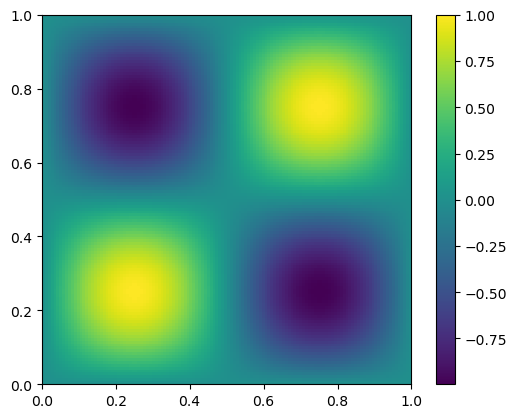

In [15]:
fig, ax = plt.subplots()

im = ax.imshow(np.transpose(v.v()),
              interpolation="nearest", origin="lower",
              extent=[mg.xmin, mg.xmax, mg.ymin, mg.ymax])
fig.colorbar(im, ax=ax)

## Comparing to the exact solution

In [16]:
phi = true(mg.x2d, mg.y2d)

With periodic BCs all around, there is nothing to normalize the solution, so we subtract off the average of $\phi$ from the MG solution to ensure it is normalized (we'll do the same with the true solution, just to be sure)

In [17]:
e = v - np.sum(v.v()) / N**2 - (phi - np.sum(phi[mg.ilo:mg.ihi+1, mg.jlo:mg.jhi+1]) / N**2)

Now we can look at the norm of the error:

In [18]:
error_norm = e.norm()
print(f"error = {error_norm:20.10g}")

error =      9.754984685e-05


and we can plot the error

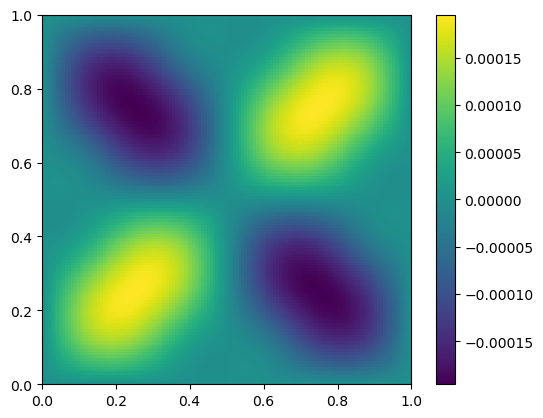

In [19]:
fig, ax = plt.subplots()

im = ax.imshow(np.transpose(e.v()),
               interpolation="nearest", origin="lower",
               extent=[mg.xmin, mg.xmax, mg.ymin, mg.ymax])
fig.colorbar(im, ax=ax)